In [1]:
#Общее описание проекта
#
# Этап 1 - загрузка первичных данных
# загружаем таблицы tracks,catalog_names,interactions
# общий вывод - присутствуют сквозные идентификаторы, основная проблема - не полностью заполнен контент с жанрами
#
# Этап 2 - EDA
# матрица U_I будет очень большой размерности
# для экономии ресурсов можно вначале отфильтровать пользователей - убрать единичные прослушивание, похожих на роботов и все расчеты сделать только на части данных
# после финализации прототипа сделать расчет на полном объеме и посмотреть на качество
# далее добавляем необходимые признаки для удобства и сохраняем в items и events
#
# Этап 3 - рекомендации
# разбиение данных - делаем глобальное разделение (global time split)
# считаем топ популярных треков - с учетом вводной по активному росту сервиса считать будем фильтруя период (например за 2е полугодие/ноябрь месяц)
# персональные рекомендации - воспользуемся als моделью, предварительно закодируем идентификаторы (пользователь id, трек id)
# похожие - для расчета похожих треков воспользуемся методом similar_items уже рассчитанной als_model

# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [2]:
#загрузим необходимые библиотеки
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time
import scipy
import sklearn.preprocessing
import numpy as np
import pickle
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool

In [3]:
start_time = time.time()

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [4]:
tracks = pd.read_parquet("data/tracks.parquet")

In [5]:
catalog_names=pd.read_parquet("data/catalog_names.parquet")

In [6]:
interactions=pd.read_parquet("data/interactions.parquet")

In [7]:
#вот тут обычно падает
interactions['month']=interactions['started_at'].dt.month

stage1_import=time.time()

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [8]:
#Таблица 1 - треки
#Данные о треках — в файле tracks.parquet:
#track_id — идентификатор музыкального трека;
#albums — список идентификаторов альбомов, содержащих трек;
#artists — список идентификаторов исполнителей трека;
#genres — список идентификаторов жанров, к которым принадлежит трек.

tracks.head(3)
#поля - id, альбомы, артисты, жанры
#числовой id, данные в столбцах кроме track_id содержат массивы

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]


In [9]:
tracks['track_id'].nunique() #1 млн треков

1000000

In [10]:
# ключевое поле заполнено без пропусков
tracks['track_id'].isna().sum()

0

In [11]:
#пустые значения в полях albums, artists, genres
genres_miss=len(tracks[(tracks['genres'].str.len() == 0)])
artist_miss=len(tracks[(tracks['artists'].str.len() == 0)])
albums_miss=len(tracks[(tracks['albums'].str.len() == 0)])
all=len(tracks)

f"пусто артистов - {artist_miss}, пусто альбомов - {albums_miss}, пусто жанров - {genres_miss}, доля пропусков - {(artist_miss+albums_miss+genres_miss)/all}"

'пусто артистов - 15369, пусто альбомов - 18, пусто жанров - 3687, доля пропусков - 0.019074'

In [12]:
#Таблица 2 - контент
#Имена артистов, названия альбомов, треков и жанров — в файле catalog_names.parquet:
#id — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
#type — тип идентификатора;
#name — имя (название) каталожной единицы.

catalog_names.head(3)

#это справочник наименований
#числовой id

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow


In [13]:
# есть дубли по id - проверим
len(catalog_names)-catalog_names['id'].nunique()

35774

In [14]:
#нет пропусков по id
catalog_names['id'].isna().sum()

0

In [15]:
#пример дубля по ключу
catalog_names.groupby('id').agg({'type':'count'}).reset_index().sort_values(by='type',ascending=False).head(10)

,id,type
171531,669527,3
12457,22057,3
16243,29496,3
3057,4474,3
99792,299507,3
45989,85456,3
159049,629396,3
12471,22076,3
122510,432903,3
71957,168409,3


In [16]:
#id не уникальные, разделим для удобства на отдельные справочники
catalog_names.query('id==669527')

,id,type,name
79463,669527,album,What Should I Write About?
696583,669527,artist,Off the Record Karaoke
887371,669527,track,Left Outside Alone


In [17]:
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [18]:
genre_cat=catalog_names.query('type=="genre"')
album_cat=catalog_names.query('type=="album"')
artist_cat=catalog_names.query('type=="artist"')
track_cat=catalog_names.query('type=="track"')

In [19]:
print(len(genre_cat)-genre_cat['id'].nunique(),len(album_cat)-album_cat['id'].nunique(), len(track_cat)-track_cat['id'].nunique(),len(artist_cat)-artist_cat['id'].nunique(),)
#теперь id являются уникальными

0 0 0 0


In [20]:
# есть неявные дубликаты по связке тип и наименование - исследуем более подробно
catalog_names[(catalog_names.duplicated(['type','name']) == True)]

,id,type,name
10,43,album,Blues Six Pack
11,45,album,Blues Six Pack
13,49,album,Graffiti Soul
28,94,album,Jazz Six Pack
29,95,album,Blues Six Pack
...,...,...,...
1812464,101458360,track,KULT
1812465,101476180,track,Февраль
1812466,101478482,track,На лицо
1812469,101495927,track,Москва


In [21]:
f"всего жанров - {len(genre_cat)},наличие дублей - {len(genre_cat)-genre_cat['name'].nunique()}"

'всего жанров - 166,наличие дублей - 0'

In [22]:
genre_cat['name'].unique()[:20]

#с наименованием жанров все хорошо

array(['all', 'eastern', 'rusrock', 'rusrap', 'postrock', 'ukrrock',
       'local-indie', 'rusbards', 'romances', 'videogame', 'tatar', 'pop',
       'shanson', 'alternative', 'rock', 'tvseries', 'dance', 'films',
       'animated', 'rusestrada'], dtype=object)

In [23]:
print(f"""всего артистов - {len(artist_cat)},
наличие дублей - {len(artist_cat)-artist_cat['name'].nunique()}, 
доля дублей {round((len(artist_cat)-artist_cat['name'].nunique())/len(artist_cat),2)}""")

всего артистов - 153581,
наличие дублей - 2385, 
доля дублей 0.02


In [24]:
#есть дубли по артистам

#например
artist_cat.groupby('name').count().reset_index().sort_values(by='id',ascending=False).head(10)

,name,id,type
52242,Iris,8,8
5195,Ali,8,8
84172,Nero,8,8
102302,Sandra,8,8
37392,Enigma,8,8
74668,Marina,7,7
107420,Snow,7,7
14092,Bianca,7,7
33018,Domino,7,7
9882,Astro,6,6


In [25]:
#есть неявные дубли по артистам
artist_cat.query('name=="Iris"')

,id,type,name
658773,258,artist,Iris
723132,2428595,artist,Iris
723133,2428598,artist,Iris
723134,2428599,artist,Iris
750668,4390811,artist,Iris
750669,4390817,artist,Iris
762878,5275494,artist,Iris
793372,8620410,artist,Iris


In [26]:
len(artist_cat[artist_cat['name'].str.replace(' ','').str.isalpha()==False]) #около 10% названий артистов содержат не текстовые символы

17845

In [27]:
#примеры - пока ничего с ними не делаем
artist_cat[artist_cat['name'].str.replace(' ','').str.isalpha()==False].sort_values(by='name').head(5)

,id,type,name
795021,8865715,artist,\tDrake
786980,7709071,artist,!
763994,5350302,artist,!!!
744529,3941033,artist,!Dela Dap
697504,694636,artist,!Deladap


In [28]:
print(f"""всего альбомов - {len(album_cat)},
наличие дублей - {len(album_cat)-album_cat['name'].nunique()}, 
доля дублей {round((len(album_cat)-album_cat['name'].nunique())/len(album_cat),2)}""")

всего альбомов - 658724,
наличие дублей - 218108, 
доля дублей 0.33


In [29]:
album_cat['name'].unique()[-10:]

array(['Exitazos Alegres', 'The Wire (Soundtrack Inspired)',
       'Marvel Movies', 'Love and Thunder (Thor Music Inspired)',
       'Alto Perreo', 'Marvel Superheroes OST (Themes) (Inspired)',
       'DC Comic Movies OST (Inspired)',
       'Dark Phoenix (Soundtrack Inspired)', 'Bailoteo Vibrante',
       'Master Composers: Johann Sebastian Bach'], dtype=object)

In [30]:
album_cat.groupby('name').count().reset_index().sort_values(by='id',ascending=False).head(5)
#это как раз нормально что встречаюстся одинаковые названия альбомов

,name,id,type
423501,Сборник,778,778
134067,Greatest Hits,622,622
131351,Gold,229,229
44343,Best Of,226,226
313313,The Best Of,216,216


In [31]:
#сравним таблицы треки и каталог
# проверка все ли треки из каталога содержатся в треках
# проверка все ли альбомы из каталога содержатся в треках
# проверка все ли артисты из каталога содержатся в треках
# проверка все ли жанры из каталога содержатся в треках
genres_list=set(tracks['genres'].explode().drop_duplicates())
catalog_list_genre=set(genre_cat['id'])

no_catalog_genre=len(catalog_list_genre-genres_list)
no_track_genre=len(genres_list-catalog_list_genre)

albums_list=set(tracks['albums'].explode().drop_duplicates())
catalog_list_album=set(album_cat['id'])

no_catalog_album=len(catalog_list_album-albums_list)
no_track_album=len(albums_list-catalog_list_album)

###
artist_list=set(tracks['artists'].explode().drop_duplicates())
catalog_list_artist=set(artist_cat['id'])

no_catalog_artist=len(catalog_list_artist-artist_list)
no_track_artist=len(artist_list-catalog_list_artist)
###
catalog_list_tracks=set(track_cat['id'])
track_list=set(tracks['track_id'])

no_catalog_track=len(catalog_list_tracks-track_list)
print(f"""жанров нет в каталоге {no_catalog_genre}, 
жанров нет в треках {no_track_genre},
доля нет жанров {no_track_genre/len(catalog_list_genre)}
альбомов нет в каталоге {no_catalog_album},
альбомов нет в треках {no_track_album},
доля нет альбомов {round(no_track_album/len(catalog_list_album),5)},
артистов нет в каталоге {no_catalog_artist},
артистов нет в треках {no_track_artist},
пропущено треков в каталоге {no_catalog_track}""")


жанров нет в каталоге 23, 
жанров нет в треках 31,
доля нет жанров 0.18674698795180722
альбомов нет в каталоге 0,
альбомов нет в треках 1,
доля нет альбомов 0.0,
артистов нет в каталоге 0,
артистов нет в треках 1,
пропущено треков в каталоге 0


In [32]:
#см долю треков с неизвестным жанром
no_catalog_genrelist=genres_list-catalog_list_genre
f"доля треков с неизвестным жанром (нет в каталоге) составляет {tracks.explode('genres').query('genres in @no_catalog_genrelist')['track_id'].nunique()/len(tracks)}"

'доля треков с неизвестным жанром (нет в каталоге) составляет 0.052032'

In [33]:
#Таблица 3 - взаимодействия - пользователь, трек, дата, track_seq — номер места трека в истории пользователя
#Данные о том, какие пользователи прослушали тот или иной трек, — в файле interactions.parquet :
#user_id — идентификатор пользователя,
#track_id — идентификатор музыкального трека,
#track_seq — номер места трека в истории пользователя,
#started_at — дата начала прослушивания трека.

interactions.head(3)

,user_id,track_id,track_seq,started_at,month
0,0,99262,1,2022-07-17,7
1,0,589498,2,2022-07-19,7
2,0,590262,3,2022-07-21,7


In [34]:
interactions['track_id'].count() #222 млн записей взаимодействия

222629898

In [35]:
#нужно вытащить год и месяц

interactions['year']=interactions['started_at'].dt.year

In [36]:
interactions.groupby(['year','month']).agg({'user_id':'nunique','track_id':'count'}).reset_index()

,year,month,user_id,track_id
0,2022,1,126224,2409541
1,2022,2,227852,4533363
2,2022,3,344333,7691225
3,2022,4,454378,10230295
4,2022,5,569813,13613489
5,2022,6,676467,16266558
6,2022,7,788369,20188819
7,2022,8,892539,23919641
8,2022,9,979781,26953965
9,2022,10,1056636,31810464


In [37]:
interactions['in_tracks']=interactions['track_id'].isin(tracks['track_id'])
interactions.query('in_tracks==False')

,user_id,track_id,track_seq,started_at,month,year,in_tracks


In [38]:
stage2_preEDA=time.time()

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [39]:
#выводы
# Таблица №1 с треками - данные в столбцах кроме track_id содержат массивы
# есть пропуски в значениях - можно восстановить или удалить
# 1 млн треков

# Таблица №2 с контентом
# ключи не уникальные - разбиваем на 4 справочника (genre_cat,album_cat,artist_cat,track_cat)
# жанры являются уникальными
# около 2% исполнителей в справочнике являются дублями
# около 10% названий исполнителей содержат не текстовые символы (возможно некорректно занесены названия в справочник)
# 33% названий всех альбомов являются дублями - это нормальная ситуация, т.к. есть часто встречающиеся "Сборник, best of..."

# сравним таблицы с треками и каталог
# есть пересортица по жанрам (23 жанра треков отсутствуют в каталоге, это 5% всех треков) - решаем что делаем в зависимости от цели исследования

# Таблица №3 взаимодействий
# данные представлены за 22 год - период активного роста (в течение года количество пользователей и прослушиваемых треков выросло в 10 раз)
# в EDA анализе интересно посмотреть как менялись списки популярных треков по месяцам
# возможно с учетом активного роста рекомендации на старых данных будут совсем нерелевантны
# все треки есть в таблице 1 с треками

# общий вывод - присутствуют сквозные идентификаторы, основная проблема - не полностью заполнен контент с жанрами

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [40]:
#Проведите EDA данных, чтобы получить представление:
#о распределении количества прослушанных треков, +
#о наиболее популярных треках, +
#о наиболее популярных жанрах, +
#о треках, которые никто не прослушал.

In [41]:
df=interactions.groupby(['user_id']).agg({'track_id':'count'}).reset_index().rename(columns={'track_id':'track_count'})
df

,user_id,track_count
0,0,26
1,1,36
2,2,14
3,3,33
4,4,256
...,...,...
1373216,1374578,11
1373217,1374579,24
1373218,1374580,277
1373219,1374581,503


In [42]:
df['track_count'].sum()/df['user_id'].count() #среднее количество песен прослушиваемых

162.12241001266366

<Axes: xlabel='track_count'>

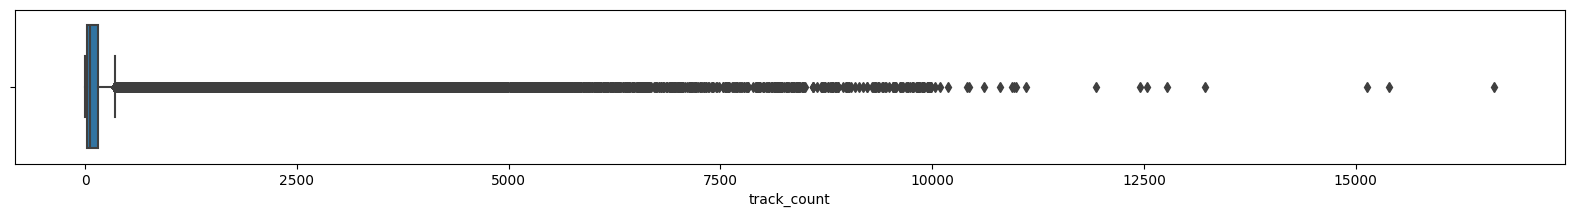

In [43]:
plt.figure(figsize=(20, 2))
sns.boxplot(df,x='track_count')

<Axes: ylabel='Frequency'>

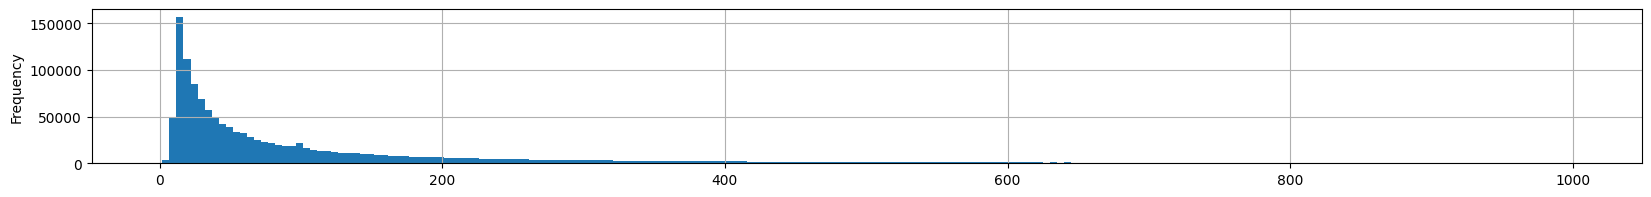

In [44]:
#смотрим распределение пользователей по количеству прослушанных треков - большинство до 1000
plt.figure(figsize=(20, 2))
df.query('track_count>1 and track_count<1000')['track_count'].plot(kind='hist',bins=200,grid=True)

In [ ]:
#для прототипа сосредоточимся на новых пользователях, которые только начинают пользоваться сервисом

#см какую долю событий отсечем из-за выбросов

user_low=df.query('track_count<30')['track_count'].sum() #мусор - считаем холодными таких пользователей
user_high=df.query('track_count>250')['track_count'].sum() #роботы и меломаны - можно удалить
print(f"не активные пользователи - {user_low},роботы - {user_high},общая доля - {round((user_low+user_high)/df['track_count'].sum(),2)}")

не активные пользователи - 8047117,роботы - 148817581,общая доля - 0.7


<Axes: xlabel='track_count'>

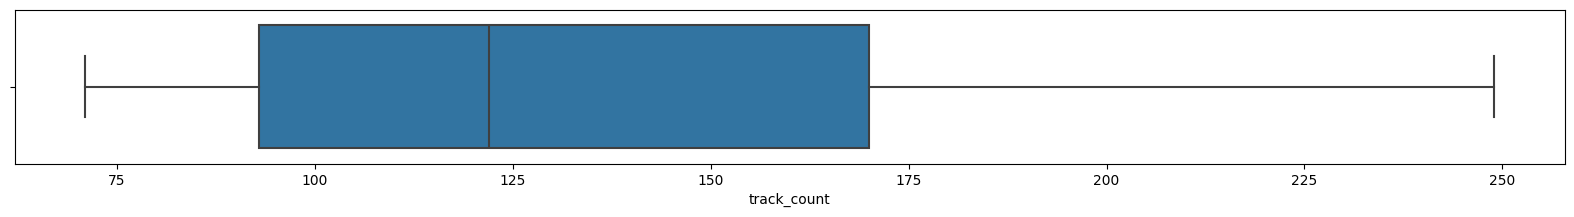

In [ ]:
#фильтруем меломанов - кто слушает более 1000 треков (сюда могут попадать роботы и специфический вкус)
# + таким образом уменьшаем массив данных, проще будет делать расчеты
# пользователей до X треков считаем холодными - они малоинформативны
df_filter=df.query('track_count>70 and track_count<250')

plt.figure(figsize=(20, 2))
sns.boxplot(df_filter,x='track_count')

In [47]:
df_filter['track_count'].sum() #сократили значительно выборку

50250845

In [48]:
good_users=df_filter['user_id']

good_interactions=interactions.query('user_id in @good_users')
good_interactions

,user_id,track_id,track_seq,started_at,month,year,in_tracks
0,5,975,1,2022-05-12,5,2022,True
1,5,18686,2,2022-05-12,5,2022,True
2,5,18705,3,2022-05-15,5,2022,True
3,5,27965,4,2022-05-19,5,2022,True
4,5,52100,5,2022-05-20,5,2022,True
...,...,...,...,...,...,...,...
130,1374577,29777253,131,2022-05-08,5,2022,True
131,1374577,30205729,132,2022-05-09,5,2022,True
132,1374577,31279977,133,2022-05-09,5,2022,True
133,1374577,31279982,134,2022-05-11,5,2022,True


In [49]:
#На шаге подготовки данных можно провести следующие действия
#a. фильтрация старых взаимодействий, которые уже или неинтересны
#b. фильтрация невалидных взаимодействий: появившихся из-за роботов

Наиболее популярные треки

In [50]:
#смотрим на популярность треков - до и после очистки от массовых пользователей (роботов и меломанов)
tracks_count=interactions.groupby('track_id').agg({'user_id':'count'}).reset_index().rename(columns={'user_id':'user_count'})

tracks_count

,track_id,user_count
0,26,5
1,38,8
2,135,16
3,136,7
4,138,17
...,...,...
999995,101478482,6
999996,101490148,72
999997,101493057,9
999998,101495927,20


<Axes: xlabel='user_count'>

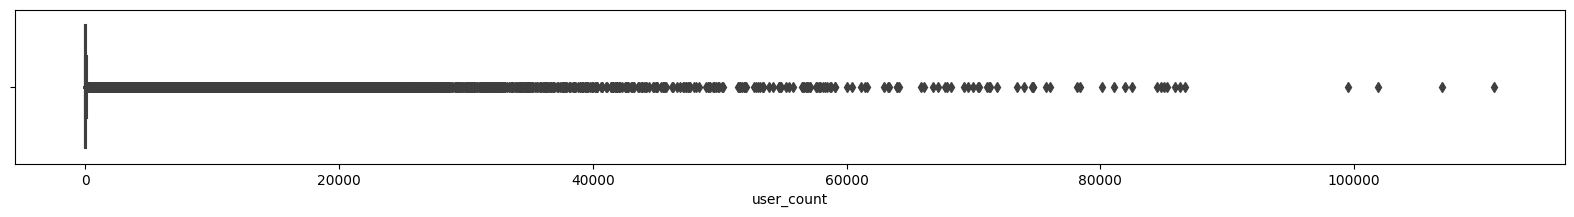

In [51]:
plt.figure(figsize=(20, 2))
sns.boxplot(tracks_count,x='user_count')

#редкие треки прослушиваются по 100 000 раз

<Axes: ylabel='Frequency'>

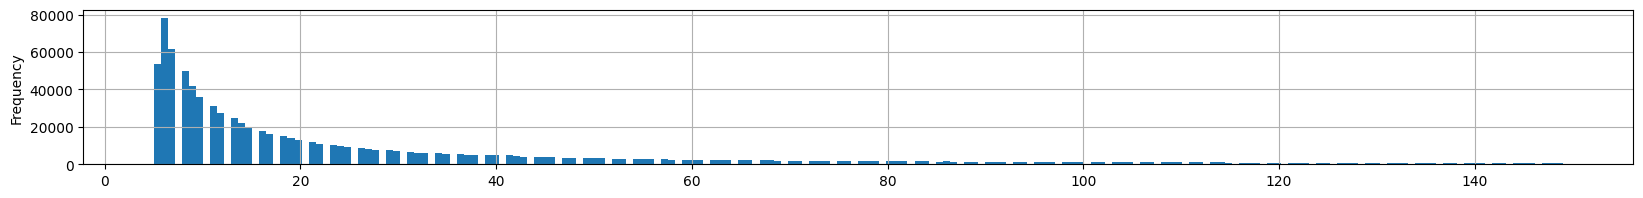

In [52]:
plt.figure(figsize=(20, 2))
tracks_count.query('user_count<150')['user_count'].plot(kind='hist',bins=200,grid=True)
#.query('track_count>1 and track_count<1000')['track_count'].plot(kind='hist',bins=200,grid=True)

In [53]:
good_tracks=tracks_count#.query('user_count>50') #фильтруем треки, которые прослушали более Х пользователей

In [54]:
#good_tracks

In [55]:
#смотрим топ популярных треков

tracks_filter_count=(interactions#good_interactions
                   .groupby('track_id')
                   .agg({'user_id':'count'})
                   .reset_index()
                   .rename(columns={'user_id':'user_count'})
                   .sort_values(by='user_count',ascending=False)
                   .head(10)
                   .merge(track_cat,left_on='track_id',right_on='id',how='left')
                   .drop(columns=['id','type']))

tracks_filter_count

,track_id,user_count,name
0,53404,111062,Smells Like Teen Spirit
1,33311009,106921,Believer
2,178529,101924,Numb
3,35505245,99490,I Got Love
4,65851540,86670,Юность
5,24692821,86246,Way Down We Go
6,32947997,85886,Shape of You
7,51241318,85244,In The End
8,795836,85042,Shape Of My Heart
9,45499814,84748,Life


<Axes: xlabel='user_count', ylabel='name'>

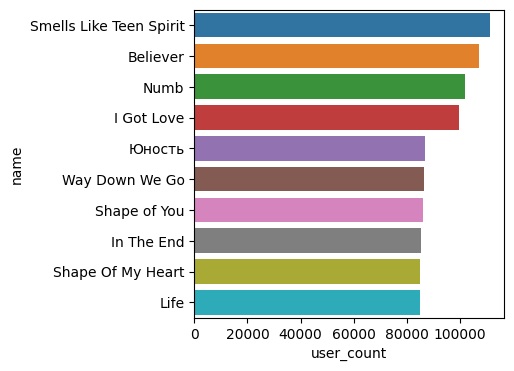

In [56]:
plt.figure(figsize=(4, 4))
sns.barplot(data=tracks_filter_count, x='user_count', y='name')

In [57]:
#смотрим теперь меняются ли предпочтения по периодам
#возможно имеет место популярность треков
pop_by_month=(interactions#good_interactions
              .groupby(['track_id','month'])
              .agg({'user_id':'count'})
              .reset_index()
              .sort_values(by=['month','user_id'],ascending=[True,False]))
pop_by_month


,track_id,month,user_id
84302,53404,1,9425
61088,37384,1,7747
18583,10216,1,6266
79298,48951,1,6156
13778,7786,1,5710
...,...,...,...
7118401,98682910,12,1
7121731,99119898,12,1
7122781,99209057,12,1
7132925,101045206,12,1


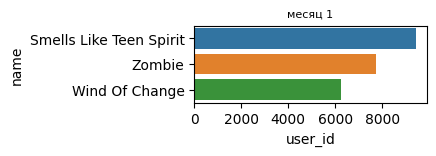

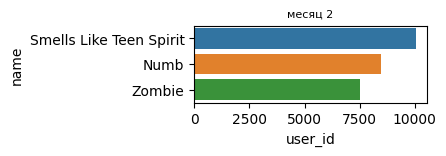

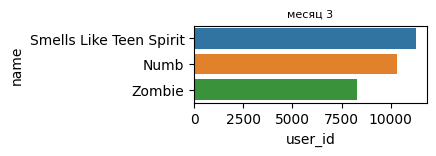

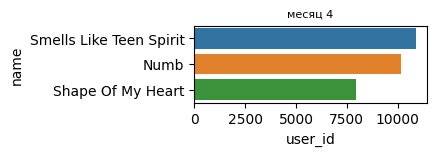

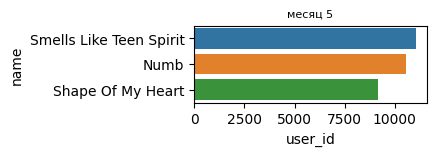

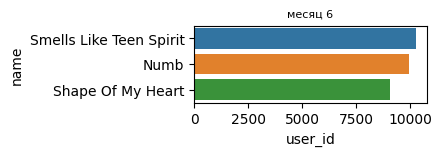

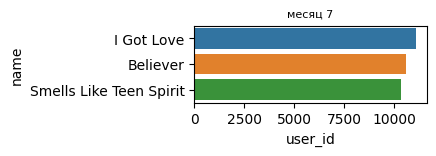

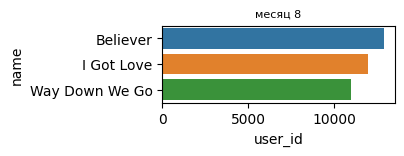

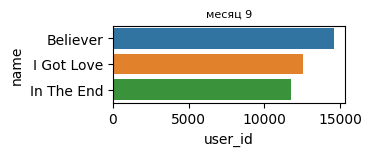

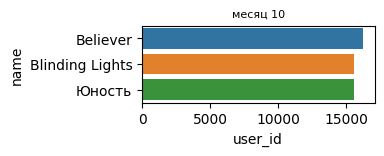

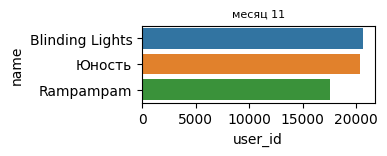

In [58]:
#есть эффект хайпа - новые песни залетают в предпочтения - вывод - для рекомендаций скорее всего надо использовать инфо за 1 -2 месяца, более поздние будем считать старыми

for i in range(1,12):
    a=pop_by_month.query('month==@i').head(3).merge(track_cat,left_on='track_id',right_on='id',how='left')
    plt.figure(figsize=(3, 1))
    sns.barplot(a, x='user_id', y='name')
    plt.title(f"месяц {i}",fontsize=8)
    plt.show()

Наиболее популярные жанры

In [59]:
test1_genre=(pop_by_month
             .query('month==1')
             #.head(3)
             .merge(tracks, on='track_id', how='left')
             .explode('genres')
             .groupby(['month','genres'])
             .agg({'track_id':'count'})
             .reset_index()
             .sort_values(by='track_id',ascending=False)
             .head(5)
             .merge(genre_cat,left_on='genres',right_on='id',how='left')
)
for i in range(2,13):
    test=(pop_by_month
             .query('month==@i')
             .merge(tracks, on='track_id', how='left')
             .explode('genres')
             .groupby(['month','genres'])
             .agg({'track_id':'count'})
             .reset_index()
             .sort_values(by='track_id',ascending=False)
             .head(5)
             .merge(genre_cat,left_on='genres',right_on='id',how='left')
    )
    test1_genre=pd.concat([test1_genre,test])


In [60]:
test1_genre['name'].unique()

array(['pop', 'allrock', 'rap', 'electronics', 'rock', 'metal', 'rusrap'],
      dtype=object)

Text(0, 0.5, 'Количество прослушиваний')

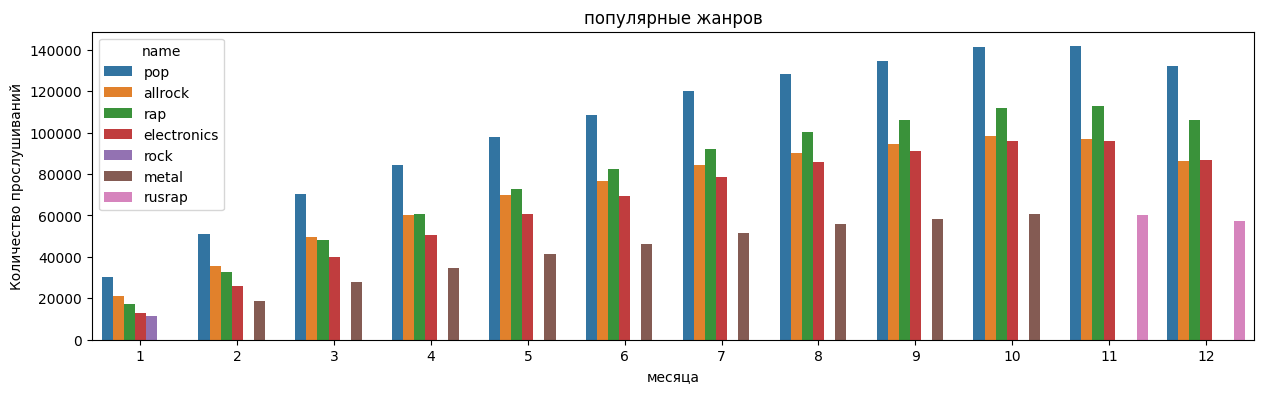

In [61]:
#смотрим динамику по жанрам
plt.figure(figsize=(15, 4))
sns.barplot(test1_genre, y='track_id', x='month',hue='name')
plt.title('популярные жанров')
plt.xlabel('месяца')
plt.ylabel('Количество прослушиваний')
# pop - самый популярный
# rap - на 2 месте
# 3 и 4 место - electronics обгоняет allrock
# 5 место - rusrap


In [62]:
#возможно для рекомендаций подойдут недельные интервалы

Треки, которые никто не прослушал

In [63]:
# получаем треки, которые не были прослушаны
unlistened_tracks = tracks[~tracks['track_id'].isin(interactions['track_id'])]
unlistened_tracks

,track_id,albums,artists,genres


In [64]:
stage3_EDA=time.time()

In [65]:
#выводы EDA
# матрица U_I будет очень большой размерности
# для экономии ресурсов можно вначале отфильтровать пользователей - убрать единичные прослушивание, похожих на роботов и все расчеты сделать только на части данных
#также можно убрать треки с единичными прослушиваниями (добавим доп условие что для попадания в рекомендации трек должен быть прослушан хотя бы N раз) - это также уменьшит выборку
# затем уже реализованный прототип использовать для более тяжелого расчета
# 
# сервис в 22 году активно рос, наиболее популярные треки меняются с течением времени (для рекомендаций в конце года мало полезны популярные треки начала года)
# популярность жанров также меняется со временем - например 3 и 4 место - electronics обгоняет allrock
# в выборке представлены треки, прослушанные хотя бы 1 раз


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [66]:
#параметры - нужны чтобы отсюда делать расчет

good_users=df.query('track_count>100 and track_count<250')['user_id']

In [67]:
interactions_1=interactions.query('user_id in @good_users') # фильтруем по пользователям

In [68]:
#time_filter=(interactions_1['started_at']<pd.to_datetime('2022-7-1'))
#interactions_2=interactions_1[~time_filter]
 # фильтруем по периоду (по результатам EDA видим что предпочтения меняются со временем + в начале 22 года сервис только запускался - возьмем в работу данные за 2 полугодие)
interactions_2=interactions_1

In [69]:
del interactions
del interactions_1

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [70]:
events = interactions_2.copy()

In [71]:
events.to_parquet('data/events.parquet')

In [72]:
del interactions_2

In [73]:
tracks_1=tracks.merge(track_cat,left_on='track_id',right_on='id',how='left')
tracks_1=tracks_1.drop(columns=['type','id'])

tracks_1

,track_id,albums,artists,genres,name
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy
2,135,"[12, 214, 2490809]",[84],[11],Atticus
3,136,"[12, 214, 2490809]",[84],[11],24 Hours
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go)
...,...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]",На лицо
999996,101490148,[21403052],[9078726],"[11, 20]",Без капли мысли
999997,101493057,[21403883],[11865715],"[44, 75]",SKITTLES
999998,101495927,[21404975],[4462686],"[3, 75]",Москва


In [74]:
#преобразование в словарь

artists_names = artist_cat.set_index('id')['name'].to_dict()
albums_names = album_cat.set_index('id')['name'].to_dict()
genres_names = genre_cat.set_index('id')['name'].to_dict()

In [75]:
# лямбда для формирования кортежей с наименованиями на основе кортежей с ids
func_albums_names = lambda x: tuple(map(albums_names.__getitem__, x))
func_artists_names = lambda x: tuple(map(artists_names.__getitem__, x))
func_genres_names = lambda x: tuple(map(genres_names.__getitem__, x))

In [76]:
tracks_1['names_of_albums_'] = tracks_1['albums'].map(func_albums_names)
tracks_1['names_of_artists'] = tracks_1['artists'].map(func_artists_names)

In [77]:
no_catalog_genrelist #неизвестные жанры
#список треков с неизвестными жанрами
tracks_no_catalog_genrelist=tracks_1.explode('genres').query('genres in @no_catalog_genrelist')['track_id']
tracks_2=tracks_1.query('track_id not in @tracks_no_catalog_genrelist')



In [78]:
good_tracks=tracks_count.query('user_count>100')
good_tracks_id=good_tracks['track_id']

tracks_2=tracks_2.query('track_id in @good_tracks_id')

In [79]:
#заполним пустые значения значениями по умолчанию, обнулим значения, которых нет в каталоге

tracks_2['names_of_genres'] = tracks_2['genres'].map(func_genres_names)

In [80]:
items = tracks_2.copy()

In [81]:
items.to_parquet('data/items.parquet')

In [82]:
del tracks
del tracks_1
del tracks_2

In [83]:
stage4_save=time.time()

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [84]:
stage5_clean=time.time()

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [85]:
events_ = pd.read_parquet('data/events.parquet')

In [86]:
events_.head(5)

,user_id,track_id,track_seq,started_at,month,year,in_tracks
0,13,33266,1,2022-03-13,3,2022,True
1,13,597343,2,2022-03-16,3,2022,True
2,13,598400,3,2022-03-20,3,2022,True
3,13,1490932,4,2022-03-21,3,2022,True
4,13,1695466,5,2022-03-24,3,2022,True


In [87]:
items_=pd.read_parquet('data/items.parquet')

In [88]:
items_.head(5)

,track_id,albums,artists,genres,name,names_of_albums_,names_of_artists,names_of_genres
7,141,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11],Never Forget You,"[Wild Young Hearts, Wild Young Hearts, I Am Wo...",[Noisettes],[pop]
28,364,[29],[291],[11],The Bandstand,[Foot Of The Mountain],[a-ha],[pop]
30,369,"[29, 163, 88381, 95472, 10319700]",[291],[11],Foot Of The Mountain,"[Foot Of The Mountain, Foot Of The Mountain, F...",[a-ha],[pop]
32,376,[29],[291],[11],What There Is,[Foot Of The Mountain],[a-ha],[pop]
33,379,"[29, 3450149]",[291],[11],Real Meaning,"[Foot Of The Mountain, Отличные песни «Радио 7...",[a-ha],[pop]


In [89]:
stage6_import=time.time()

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [90]:
#Ссылка на урок: [Спринт 5/13: 4 спринт. Создание рекомендательной системы → Тема 2/7: Знакомство с рекомендательными системами → Урок 4/6: Холодный старт]
# ( https://practicum.yandex.ru/learn/machine-learning/courses/c3a487f1-0200-4fe8-8acb-f17d39b5a167/sprints/376678/topics/136ab50a-1f9b-4e46-b05d-a71e5d44e1fc/lessons/088ead09-7d7b-412e-bd25-172bc05a77da/#eb607c75-c509-4d14-92ae-ba1f5ef69b62 )


In [91]:
# зададим точку разбиения (сразу учтем что для модели ранжирования нужна будет доп разбивка для получения таргетов)
#пробую сделать разбивку с 01.12 по 20.12 и с 20.12 по 31.12. качество измеряю с 20 по 31.12
train_test_global_time_split_date = pd.to_datetime('2022-12-01')#('2022-12-20')
train_test_global_time_split_date_catboost = pd.to_datetime('2022-12-20')

train_test_global_time_split_idx = events_["started_at"] < train_test_global_time_split_date
for_test=events_["started_at"] > pd.to_datetime('2022-12-20')
for_catboost=(train_test_global_time_split_date<=events_["started_at"])&(events_["started_at"] <= pd.to_datetime('2022-12-20'))

events_train = events_[train_test_global_time_split_idx]
events_catboost=events_[for_catboost]
events_test = events_[for_test]

In [92]:
#проверяю даты
#events_test['started_at'].max()

In [93]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
users_catboost = events_catboost["user_id"].drop_duplicates()

# количество пользователей, которые есть и в train, и в test
common_users = events_["user_id"].drop_duplicates()

print(len(users_train), len(users_test), len(common_users),len(users_catboost)) 

239738 120928 250255 181351


In [94]:
#делаю датафреймы с тест/train и всеми пользователями

pd_users_test=pd.DataFrame(users_test)
pd_users_test['name']='test'

pd_users_train=pd.DataFrame(users_train)
pd_users_train['name_train']='train'

pd_common_users=pd.DataFrame(common_users)
pd_common_users['all']='all'

pd_users_catboost=pd.DataFrame(users_train)
pd_users_catboost['name_cat']='catboost'

In [95]:
#получились холодные пользователм
USERS = pd_common_users.set_index('user_id').join([pd_users_test.set_index('user_id'),pd_users_train.set_index('user_id'),pd_users_catboost.set_index('user_id')],how='left').reset_index().fillna(0)
USERS.head(5)

,user_id,all,name,name_train,name_cat
0,13,all,test,train,catboost
1,19,all,test,train,catboost
2,24,all,0,train,catboost
3,26,all,test,train,catboost
4,33,all,0,train,catboost


In [96]:
#для наглядности общая таблица пользователей с пометками наличия в тренировочной/тестовой выборке - USER
#можем посчитать долю пользователей, которые попали в обе выборки от общей выборки тестовой
both_users=len(USERS.query('name=="test" and name_train=="train"'))

print(f"пользователи в 2х выборках - {both_users}, что составляет {round(both_users/len(users_test),3)} от общих пользователей теста")
#в целом хорошее получилось разделение, 97% общих пользователей, холодных пользователей 3%, событий train в 2 раза больше, чем в тесте

пользователи в 2х выборках - 110488, что составляет 0.914 от общих пользователей теста


In [97]:
# посчитаем количество "холодных" пользователей.
cold_users_=USERS.query('name!=0 and name_train==0')['user_id']
len(cold_users_)

10440

In [98]:
cold_users_

45            376
52            420
93            640
203          1280
260          1603
           ...   
250170    1374057
250176    1374090
250196    1374210
250216    1374361
250234    1374455
Name: user_id, Length: 10440, dtype: int32

In [99]:
stage7_split=time.time()

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [100]:
#Ссылка на урок: [Спринт 5/13: 4 спринт. Создание рекомендательной системы → Тема 2/7: Знакомство с рекомендательными системами → Урок 4/6: Холодный старт]
# ( https://practicum.yandex.ru/learn/machine-learning/courses/c3a487f1-0200-4fe8-8acb-f17d39b5a167/sprints/376678/topics/136ab50a-1f9b-4e46-b05d-a71e5d44e1fc/lessons/088ead09-7d7b-412e-bd25-172bc05a77da/#2e32a7f5-3687-43d2-affa-5d510ce57a70 )

In [101]:
item_popularity = events_train.groupby('track_id').agg(track_count=("user_id","count")).reset_index().sort_values(by='track_count',ascending=False)
item_popularity.head(5)

,track_id,track_count
7903,53404,24804
23139,178529,22988
419908,35505245,21693
397386,33311009,21462
76593,795836,18279


In [102]:
# нормализация:

x_min=item_popularity['track_count'].min()
x_max=item_popularity['track_count'].max()
item_popularity['score']=round(item_popularity['track_count'].apply(lambda x: (x-x_min)/(x_max-x_min)),2)
top_k_pop_items=item_popularity[["track_id","score"]].head(10)
top_k_pop_items

,track_id,score
7903,53404,1.00
23139,178529,0.93
419908,35505245,0.87
397386,33311009,0.87
76593,795836,0.74
304410,24692821,0.73
5742,37384,0.69
164815,6705392,0.69
525183,45499814,0.69
390651,32947997,0.68


In [103]:
top_k_pop_items_names=top_k_pop_items.merge(items_,on='track_id',how='left')[['track_id','score','name']]
top_k_pop_items_names

,track_id,score,name
0,53404,1.00,Smells Like Teen Spirit
1,178529,0.93,Numb
2,35505245,0.87,I Got Love
3,33311009,0.87,Believer
4,795836,0.74,Shape Of My Heart
5,24692821,0.73,Way Down We Go
6,37384,0.69,Zombie
7,6705392,0.69,Seven Nation Army
8,45499814,0.69,Life
9,32947997,0.68,Shape of You


In [104]:
events_test

,user_id,track_id,track_seq,started_at,month,year,in_tracks
134,13,63678479,135,2022-12-21,12,2022,True
135,13,63678480,136,2022-12-22,12,2022,True
136,13,64453581,137,2022-12-29,12,2022,True
174,19,72373145,175,2022-12-24,12,2022,True
175,19,75211163,176,2022-12-24,12,2022,True
...,...,...,...,...,...,...,...
138,1374566,81581652,139,2022-12-21,12,2022,True
139,1374566,83063895,140,2022-12-21,12,2022,True
140,1374566,92139043,141,2022-12-21,12,2022,True
141,1374566,92448525,142,2022-12-22,12,2022,True


In [105]:
#получили рекомендации по умолчанию - default recommendations
#оценим их качество - соотнесем с событиями из теста
cold_users_with_recs=events_test[events_test["user_id"].isin(cold_users_)].merge(top_k_pop_items_names,on='track_id',how='left')

cold_users_with_recs_len=cold_users_with_recs['user_id'].nunique()
cold_users_with_recs_positive_len=len(cold_users_with_recs.query('score>0'))
print(f"доля пользователей использующих default rec - {cold_users_with_recs_positive_len/cold_users_with_recs_len}")

#20 % пользователей - для старта хороший показатель
#вывод - треки из top_k_pop достаточно популярны
#Такие рекомендации полезны, но их нельзя назвать персональными

доля пользователей использующих default rec - 0.17346743295019157


In [106]:
# Сохраняем локально
top_k_pop_items_names.to_parquet('recs/top_k_pop_items_names.parquet')

In [107]:
recom_top = (
    events_test[['user_id']]
    .drop_duplicates()
    .reset_index(drop=True)
    .merge(top_k_pop_items_names, how='cross')
    .reset_index(drop=True)
)[['user_id','track_id','score']]
recom_top.head(5)

,user_id,track_id,score
0,13,53404,1.00
1,13,178529,0.93
2,13,35505245,0.87
3,13,33311009,0.87
4,13,795836,0.74


In [108]:
recom_top.to_parquet("recs/recom_top.parquet")

In [109]:
stage8_pop=time.time()

# Персональные

Рассчитаем персональные рекомендации.

In [110]:
#надо из events удалить события без items
events_train=events_train[events_train['track_id'].isin(items_['track_id'])]
events_test=events_test[events_test['track_id'].isin(items_['track_id'])]
events_catboost=events_catboost[events_catboost['track_id'].isin(items_['track_id'])]

In [111]:
#оценим разреженность оценок
a=events_train['user_id'].nunique()
b=events_train['track_id'].nunique()
c=len(events_train)
c/(a*b)*100
#всего вариантов a*b
#значений в U-I матрице заполнено, матрица сильно разрежена

0.06563426325830517

In [112]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events_["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])

In [113]:
# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items_["track_id"])
items_["track_id_enc"] = item_encoder.transform(items_["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])

In [114]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    np.ones(len(events_train)),
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)

user_item_matrix_train #матрица пользователь треки

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 29659869 stored elements and shape (250255, 188619)>

In [115]:
#получим рейтинги на основе коллаборативных фильтраций на основе ALS
als_model = AlternatingLeastSquares(factors=40, iterations=5, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

100%|██████████| 5/5 [00:26<00:00,  5.26s/it]


In [116]:
with open('models/als_model.pkl', 'wb') as f:
       pickle.dump(als_model, f)

In [117]:
with open('models/als_model.pkl', 'rb') as f:
    als_model = pickle.load(f)

In [118]:
#Ссылка на урок: [Спринт 5/13: 4 спринт. Создание рекомендательной системы → Тема 3/7: Базовые рекомендации: коллаборативный и контентный подходы → Урок 2/5: 
# Коллаборативная фильтрация: ALS]( https://practicum.yandex.ru/learn/machine-learning/courses/c3a487f1-0200-4fe8-8acb-f17d39b5a167/sprints/376678/topics/42573e55-b1cd-4139-ac25-be6141f90e15/lessons/2ca92243-659b-4b2d-8a95-579c00ff6487/#d36dd3e5-b015-4636-a175-971a6bfc4fbd )

#Чтобы получить рекомендации для пользователя с помощью модели ALS, используем такую функцию:

def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [119]:
#используя обученную модель, получим рекомендации для тестовой выборки
#Проверка метрик на адекватность - сравним со случайными рекомендациями

#смотрим пример рекомендации - !! ПОЛЬЗОВАТЕЛИ ИЗ ОБЕИХ ВЫБОРОК
both_=USERS.query('name=="test" and name_train=="train"').reset_index()['user_id']
user_id_example=events_train.query('user_id in @both_')['user_id'].sample().iat[0]
user_id_example

1208686

In [120]:
#проверяю что есть
events_test.query('user_id==@user_id_example')

,user_id,track_id,track_seq,started_at,month,year,in_tracks
164,1208686,68102703,165,2022-12-21,12,2022,True
165,1208686,69069639,166,2022-12-22,12,2022,True
166,1208686,69374769,167,2022-12-22,12,2022,True
167,1208686,69461987,168,2022-12-23,12,2022,True
168,1208686,70606281,169,2022-12-24,12,2022,True
169,1208686,70975354,170,2022-12-24,12,2022,True
170,1208686,71766068,171,2022-12-24,12,2022,True
171,1208686,72797986,172,2022-12-25,12,2022,True
172,1208686,73558460,173,2022-12-25,12,2022,True
173,1208686,73745579,174,2022-12-26,12,2022,True


In [121]:
als_test_user=get_recommendations_als(user_item_matrix_train, als_model, user_id_example, user_encoder, item_encoder)
als_test_user

,item_id_enc,score,item_id
0,84877,1.127830,32947997
1,75192,1.105341,29544272
2,86257,1.101014,33311009
3,63539,0.987479,24692821
4,60480,0.969681,23559960


In [122]:
als_test_user_track=als_test_user.merge(items_,left_on='item_id',right_on='track_id',how='left')
als_test_user_track['result']=1

als_test_user_track

,item_id_enc,score,item_id,track_id,albums,artists,genres,name,names_of_albums_,names_of_artists,names_of_genres,track_id_enc,result
0,84877,1.127830,32947997,32947997,"[4019560, 4172930, 4172931, 5614201, 5933975]",[381067],[11],Shape of You,"[Shape of You, ÷, ÷, Summer Vibes, Pop]",[Ed Sheeran],[pop],84877,1
1,75192,1.105341,29544272,29544272,"[3554367, 4088112, 4864923, 4875594, 5553587, ...",[1113157],"[25, 70]",Human,"[Human, Human, Some Chillout Music, Music Made...",[Rag'n'Bone Man],"[soundtrack, indie]",75192,1
2,86257,1.101014,33311009,33311009,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],"[14, 102]",Believer,"[Shape Of Pop, NOW That's What I Call Music, E...",[Imagine Dragons],"[rock, allrock]",86257,1
3,63539,0.987479,24692821,24692821,"[2888516, 3523463, 3530199, 4333848, 4420934, ...",[1194096],[70],Way Down We Go,"[Way down We Go, Summer Music 2016, A/B, DFM D...",[KALEO],[indie],63539,1
4,60480,0.969681,23559960,23559960,"[2719136, 2747498, 3361936, 3523463, 3600798, ...",[792433],[70],Stressed Out,"[Stressed Out, Blurryface, Spring Music 2016, ...",[twenty one pilots],[indie],60480,1


In [123]:
#см фактические результаты у пользователя и есть ли пересечение - пересечения нет
events_test.query('user_id==@user_id_example').merge(items_,on='track_id',how='left').merge(als_test_user_track,on='track_id',how='left')

,user_id,track_id,track_seq,started_at,month,year,in_tracks,albums_x,artists_x,genres_x,...,item_id,albums_y,artists_y,genres_y,name_y,names_of_albums__y,names_of_artists_y,names_of_genres_y,track_id_enc_y,result
0,1208686,68102703,165,2022-12-21,12,2022,True,"[11256975, 11980686, 12132366, 12282596, 12361...","[4117141, 626515]",[16],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1208686,69069639,166,2022-12-22,12,2022,True,"[11515560, 14514213]","[5798713, 7214574]",[11],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1208686,69374769,167,2022-12-22,12,2022,True,"[11600105, 15964067]",[3685211],[74],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1208686,69461987,168,2022-12-23,12,2022,True,"[11624271, 12161688, 12858958]",[5821649],[11],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1208686,70606281,169,2022-12-24,12,2022,True,"[11941922, 12322097]","[5145563, 110143]","[11, 60]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1208686,70975354,170,2022-12-24,12,2022,True,"[12044548, 12711272, 14741182]","[4149935, 4163023]","[16, 68, 101]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1208686,71766068,171,2022-12-24,12,2022,True,"[12267366, 12433984, 12614048, 13796953, 13796...","[3889375, 4733099]",[11],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1208686,72797986,172,2022-12-25,12,2022,True,"[12564972, 12727216, 12887104, 13987595, 14404...","[495928, 5343458]","[11, 16]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1208686,73558460,173,2022-12-25,12,2022,True,"[12780619, 16971142, 17025183, 17028200, 17028...",[4353492],[70],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1208686,73745579,174,2022-12-26,12,2022,True,"[12832958, 12914177, 12914246]","[4813, 3889375]",[11],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
#Получим рекомендации для всех имеющихся пользователей
user_ids_encoded = range(len(user_encoder.classes_))
user_ids_encoded

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=4) 

als_recommendations

(array([[ 37441,  24146,  24519, 104670],
        [ 27260,   2609,   6567,    583],
        [ 35955,  17146,  22587,  13870],
        ...,
        [ 51780, 134006,  82214, 104745],
        [122674, 136622,  97045,  89803],
        [ 16812,   6059,  75050,  17146]], dtype=int32),
 array([[0.3833414 , 0.25547522, 0.2510152 , 0.23131016],
        [0.8281345 , 0.80979043, 0.76545143, 0.7477067 ],
        [0.35212108, 0.30088383, 0.28600797, 0.26276985],
        ...,
        [0.3432267 , 0.28014788, 0.2644191 , 0.25843668],
        [0.38079312, 0.27780908, 0.2734208 , 0.23887886],
        [0.0260613 , 0.02524364, 0.02390427, 0.0226514 ]], dtype=float32))

In [125]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [126]:
als_recommendations=als_recommendations.rename(columns={'item_id':'track_id'})
als_recommendations

,score,user_id,track_id
0,0.383341,13,9282507
1,0.255475,13,2192826
2,0.251015,13,2200948
3,0.231310,13,39632975
4,0.828134,19,2758009
...,...,...,...
1001015,0.238879,1374572,34735046
1001016,0.026061,1374577,679169
1001017,0.025244,1374577,148092
1001018,0.023904,1374577,29456722


In [127]:
#для расчета метрик кодирую тест

events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])

In [128]:
#сохраним рекомендации
als_recommendations.to_parquet("recs/als_recommendations.parquet")

In [129]:
stage9_ALS=time.time()

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [130]:
#воспользуемся уже известным алгоритмом ALS из библиотеки implicit, у которого на такой случай есть удобный метод similar_items
#ссылка на документацию https://benfred.github.io/implicit/api/models/cpu/als.html#implicit.cpu.als.AlternatingLeastSquares.similar_items

In [131]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['track_id_enc'].unique()
train_item_ids_enc

array([  1587,  13342,  13435, ..., 183551, 167929, 157231])

In [132]:
max_similar_items = 2
# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

In [133]:
# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_item_ids_enc,
    "sim_track_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_track_id_enc", "score"], ignore_index=True)

In [134]:
# приводим типы данных
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_enc"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_enc"])
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("track_id_1 != track_id_2")

In [135]:
track_names_=items_[['track_id','name','names_of_genres','names_of_artists','names_of_albums_']]

In [136]:
#смотрю на примерах - действительно похожие рекомендации по жанрам, исполнителям
similar_items.head(10).merge(track_names_,left_on='track_id_1',right_on='track_id',how='left').merge(track_names_,left_on='track_id_2',right_on='track_id',how='left')

,score,track_id_1,track_id_2,track_id_x,name_x,names_of_genres_x,names_of_artists_x,names_of_albums__x,track_id_y,name_y,names_of_genres_y,names_of_artists_y,names_of_albums__y
0,0.963317,33266,33269,33266,The Love Song,"[metal, industrial]",[Marilyn Manson],"[Lest We Forget: The Best Of, Lest We Forget (...",33269,The Dope Show,"[metal, industrial]",[Marilyn Manson],"[Lest We Forget: The Best Of, Mechanical Anima..."
1,0.958086,33266,806977,33266,The Love Song,"[metal, industrial]",[Marilyn Manson],"[Lest We Forget: The Best Of, Lest We Forget (...",806977,Valentine's Day,"[metal, industrial]",[Marilyn Manson],[Holy Wood (In The Shadow Of The Valley Of Dea...
2,0.972907,597343,41189573,597343,Вот пуля просвистела…,"[rusrock, allrock]",[Чиж & Co],[О любви],41189573,Не спеши,"[rusrock, allrock]",[ЧайФ],[Дети гор]
3,0.954911,597343,40616689,597343,Вот пуля просвистела…,"[rusrock, allrock]",[Чиж & Co],[О любви],40616689,Не спеши,"[rusrock, allrock]",[ЧайФ],[Концерт]
4,0.961289,598400,35798083,598400,Свобода,"[rusrock, allrock]",[Ленинград],[Хлеб],35798083,Группа крови,"[rusrock, allrock]",[Виктор Цой],[Виктор Цой 55]
5,0.941505,598400,598365,598400,Свобода,"[rusrock, allrock]",[Ленинград],[Хлеб],598365,Скорость,"[films, soundtrack]",[Сергей Шнуров],[«Бумер 2»]
6,0.948153,1490932,28122737,1490932,Фонари,"[rusrock, allrock]",[Город 312],[Вне зоны доступа],28122737,Для тебя,"[rusrock, allrock]",[Звери],[Всё лучшее в одном]
7,0.945395,1490932,2302050,1490932,Фонари,"[rusrock, allrock]",[Город 312],[Вне зоны доступа],2302050,Холодным мужчинам,"[rusrock, allrock]",[Мара],[Откровенность]
8,0.961971,1695466,20878423,1695466,В последнюю осень,"[rusrock, allrock]",[ДДТ],[Актриса Весна],20878423,Напои меня водой,"[rusrock, allrock]","[Гарик Сукачёв, Неприкасаемые]","[Лучшее, Ч. 1, Лучшее, Ч. 1, The Best]"
9,0.959256,1695466,10731250,1695466,В последнюю осень,"[rusrock, allrock]",[ДДТ],[Актриса Весна],10731250,Однажды мир прогнётся под нас,"[rusrock, allrock]",[Машина времени],[Отрываясь]


In [137]:
similar_items.to_parquet("recs/similar.parquet") 

In [138]:
stage10_similar=time.time()

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# === часть 1 - расчет для events_train ===

In [139]:
#сначала обрабатываю полученные ранее расчеты
#затем делаю рекомендации для выделенного на catboost периода
#делаю прогноз для новых поступивших данных

In [140]:
#ЧАСТЬ 1 - сначала обрабатываю полученные ранее расчеты

In [141]:
#возьмем рассчитанные ранее рекомендации из train
popularity_recommendations=pd.read_parquet("recs/recom_top.parquet")
als_recommendations=pd.read_parquet("recs/als_recommendations.parquet")

In [142]:
candidates = pd.merge(
    als_recommendations[["user_id", "track_id", "score"]].rename(columns={"score": "als_score"}),
    popularity_recommendations[["user_id", "track_id", "score"]].rename(columns={"score": "pop_score"}),
    on=['user_id','track_id'],
    how="outer").fillna(0)

In [143]:
print(f"доля совпадений в рекомендациях - {round(len(candidates.query('als_score!=0 and pop_score!=0'))/len(candidates),3)}")

доля совпадений в рекомендациях - 0.04


In [144]:
# добавляем таргеты
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных 

events_catboost["target"] = 1

candidates = candidates.merge(events_catboost[["user_id", "track_id", "target"]], on=['user_id','track_id'],how='outer').fillna(0)
candidates


,user_id,track_id,als_score,pop_score,target
0,13,9282507,0.383341,0.0,0.0
1,13,2192826,0.255475,0.0,0.0
2,13,2200948,0.251015,0.0,0.0
3,13,39632975,0.231310,0.0,0.0
4,19,2758009,0.828134,0.0,0.0
...,...,...,...,...,...
6951576,1374571,91953221,0.000000,0.0,1.0
6951577,1374571,93000514,0.000000,0.0,1.0
6951578,1374571,93099578,0.000000,0.0,1.0
6951579,1374571,93126179,0.000000,0.0,1.0


In [145]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)
candidates_to_sample

,user_id,track_id,als_score,pop_score,target
0,13,9282507,0.383341,0.0,0.0
1,13,2192826,0.255475,0.0,0.0
2,13,2200948,0.251015,0.0,0.0
3,13,39632975,0.231310,0.0,0.0
4,19,2758009,0.828134,0.0,0.0
...,...,...,...,...,...
6951576,1374571,91953221,0.000000,0.0,1.0
6951577,1374571,93000514,0.000000,0.0,1.0
6951578,1374571,93099578,0.000000,0.0,1.0
6951579,1374571,93126179,0.000000,0.0,1.0


In [146]:
candidates_to_sample.loc[candidates_to_sample['target']==0,'target_negative']=1
candidates_to_sample=candidates_to_sample.fillna(0)
candidates_to_sample

,user_id,track_id,als_score,pop_score,target,target_negative
0,13,9282507,0.383341,0.0,0.0,1.0
1,13,2192826,0.255475,0.0,0.0,1.0
2,13,2200948,0.251015,0.0,0.0,1.0
3,13,39632975,0.231310,0.0,0.0,1.0
4,19,2758009,0.828134,0.0,0.0,1.0
...,...,...,...,...,...,...
6951576,1374571,91953221,0.000000,0.0,1.0,0.0
6951577,1374571,93000514,0.000000,0.0,1.0,0.0
6951578,1374571,93099578,0.000000,0.0,1.0,0.0
6951579,1374571,93126179,0.000000,0.0,1.0,0.0


In [147]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы 3 отрицательных таргета
candidates_to_sample = candidates_to_sample.groupby("user_id").filter(lambda x: x["target_negative"].sum() >= 3)
candidates_to_sample

,user_id,track_id,als_score,pop_score,target,target_negative
0,13,9282507,0.383341,0.0,0.0,1.0
1,13,2192826,0.255475,0.0,0.0,1.0
2,13,2200948,0.251015,0.0,0.0,1.0
3,13,39632975,0.231310,0.0,0.0,1.0
4,19,2758009,0.828134,0.0,0.0,1.0
...,...,...,...,...,...,...
6951576,1374571,91953221,0.000000,0.0,1.0,0.0
6951577,1374571,93000514,0.000000,0.0,1.0,0.0
6951578,1374571,93099578,0.000000,0.0,1.0,0.0
6951579,1374571,93126179,0.000000,0.0,1.0,0.0


In [148]:
#по 1 положительному таргету
candidates_to_sample.groupby('target')['user_id'].count()

target
0.0    1819865
1.0    4846341
Name: user_id, dtype: int64

In [149]:
#есть по 1 положительному примеру
#candidates_to_sample.query('target==1').groupby('user_id').agg({'track_id':'count'}).reset_index().sort_values(by='track_id')

candidates_to_sample.query('target==0').groupby('user_id').agg({'track_id':'count'}).reset_index().sort_values(by='track_id')


,user_id,track_id
1985,15497,3
1781,14039,3
178552,1361995,3
1591,12664,3
178732,1363390,3
...,...,...
180195,1374571,14
0,13,14
180186,1374491,14
87817,666312,14


In [150]:
# для каждого пользователя оставляем только 2 негативных примера
negatives_per_user = 3
candidates_X = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ],ignore_index=True)

In [151]:
candidates_X

,user_id,track_id,als_score,pop_score,target,target_negative
0,209,50685843,0.134748,0.00,1.0,0.0
1,539,795836,0.069413,0.74,1.0,0.0
2,936,81848875,0.273018,0.00,1.0,0.0
3,1075,33308946,0.175631,0.00,1.0,0.0
4,1075,30380200,0.156025,0.00,1.0,0.0
...,...,...,...,...,...,...
5386924,1374568,36963198,0.076668,0.00,0.0,1.0
5386925,1374568,41920901,0.082197,0.00,0.0,1.0
5386926,1374571,795836,0.000000,0.74,0.0,1.0
5386927,1374571,35505245,0.000000,0.87,0.0,1.0


In [152]:
#обучение модели

# задаём имена колонок признаков и таргета
features = ['als_score', 'pop_score']
target = 'target'


# создаём Pool
train_data = Pool(
    data=candidates_X[features], 
    label=candidates_X[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

# Посмотрим на важность признаков построенной модели
pd.DataFrame(
    cb_model.get_feature_importance(), 
    index=features, 
    columns=['feature_importance']
).sort_values(by='feature_importance', ascending=False)


0:	learn: 0.3839384	total: 479ms	remaining: 3m 59s
100:	learn: 0.0163666	total: 35.2s	remaining: 2m 19s
200:	learn: 0.0163554	total: 1m 7s	remaining: 1m 40s
300:	learn: 0.0163557	total: 1m 40s	remaining: 1m 6s
400:	learn: 0.0163551	total: 2m 13s	remaining: 32.8s
499:	learn: 0.0163495	total: 2m 45s	remaining: 0us


,feature_importance
pop_score,51.664415
als_score,48.335585


In [153]:
#получение рекомендаций
candidates_X

,user_id,track_id,als_score,pop_score,target,target_negative
0,209,50685843,0.134748,0.00,1.0,0.0
1,539,795836,0.069413,0.74,1.0,0.0
2,936,81848875,0.273018,0.00,1.0,0.0
3,1075,33308946,0.175631,0.00,1.0,0.0
4,1075,30380200,0.156025,0.00,1.0,0.0
...,...,...,...,...,...,...
5386924,1374568,36963198,0.076668,0.00,0.0,1.0
5386925,1374568,41920901,0.082197,0.00,0.0,1.0
5386926,1374571,795836,0.000000,0.74,0.0,1.0
5386927,1374571,35505245,0.000000,0.87,0.0,1.0


In [154]:
stage11_catboost_base=time.time()

# === часть 2.1 - прошло время - топ популярных ===

In [155]:
#Часть 2 - прошло время - объединяем выборки train и catboost, получаем комментарии


In [156]:
#ТОП ПОПУЛЯРНЫХ
#обернем в функцию, чтобы можно было переиспользовать многократно
def popularity_score(df,df_rec,k):
    #сортировка треков
    item_popularity = df.groupby('track_id').agg(track_count=("user_id","count")).reset_index().sort_values(by='track_count',ascending=False)
    #нормализация
    x_min=item_popularity['track_count'].min()
    x_max=item_popularity['track_count'].max()
    item_popularity['score']=item_popularity['track_count'].apply(lambda x: (x-x_min)/(x_max-x_min))
    top_k_pop_items=item_popularity[["track_id","score"]].head(k)
    top_k_pop_items_names=top_k_pop_items.merge(items_,on='track_id',how='left')[['track_id','score','name']]
    recom_top = (
    df[['user_id']]
    .drop_duplicates()
    .reset_index(drop=True)
    .merge(top_k_pop_items_names, how='cross')
    .reset_index(drop=True))

    return recom_top

In [157]:
events_train2=pd.concat([events_train,events_catboost])

In [158]:
#рекомендации новые
recom_top_2=popularity_score(events_train2,events_test,10)
recom_top_2

,user_id,track_id,score,name
0,13,53404,1.000000,Smells Like Teen Spirit
1,13,33311009,0.944194,Believer
2,13,178529,0.929405,Numb
3,13,35505245,0.919199,I Got Love
4,13,65851540,0.772270,Юность
...,...,...,...,...
2502115,1374515,45499814,0.766147,Life
2502116,1374515,24692821,0.763258,Way Down We Go
2502117,1374515,51241318,0.753861,In The End
2502118,1374515,32947997,0.749162,Shape of You


In [159]:
recom_top_2.to_parquet("recs/recom_top_2.parquet")

In [160]:
stage12_for_catboost_pop=time.time()

# === часть 2.2 - прошло время - персональные ===

In [161]:
#сделаем расчет ALS надо из events удалить события без items
events_train2=events_train2[events_train2['track_id'].isin(items_['track_id'])]

In [162]:
events_train2['user_id_enc'].nunique()

239692

In [163]:
events_train2['track_id_enc'].nunique()

188532

In [164]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events_train2["user_id"])
events_train2["user_id_enc"] = user_encoder.transform(events_train2["user_id"])

In [165]:
# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items_["track_id"])
items_["track_id_enc"] = item_encoder.transform(items_["track_id"])
events_train2["track_id_enc"] = item_encoder.transform(events_train2["track_id"])

In [166]:
#убедимся что старая переменная удалена и скопируем старый код 
del user_item_matrix_train

In [167]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    np.ones(len(events_train2)),
    (events_train2['user_id_enc'], events_train2['track_id_enc'])),
    dtype=np.int8)

user_item_matrix_train #матрица пользователь треки

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 34508232 stored elements and shape (250212, 188619)>

In [168]:
#получим рейтинги на основе коллаборативных фильтраций на основе ALS
als_model_catboost = AlternatingLeastSquares(factors=50, iterations=10, regularization=0.05, random_state=0)
als_model_catboost.fit(user_item_matrix_train) 

100%|██████████| 10/10 [01:20<00:00,  8.04s/it]


In [169]:
with open('models/als_model_catboost.pkl', 'wb') as f:
       pickle.dump(als_model_catboost, f)

In [170]:
with open('models/als_model_catboost.pkl', 'rb') as f:
    als_model_catboost = pickle.load(f)

In [171]:
#Получим рекомендации для всех имеющихся пользователей
user_ids_encoded = range(len(user_encoder.classes_))
user_ids_encoded

# получаем рекомендации для всех пользователей
als_recommendations = als_model_catboost.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=5) 

als_recommendations


(array([[ 37441, 104670,  51827,  12337,  24519],
        [ 27260,   2609,  19141,    583,  71237],
        [144965,  35955,  84468,  51070,  25434],
        ...,
        [ 51780, 134006, 104745,  86257, 125692],
        [122674, 136622,  97045,  57382, 163978],
        [ 16812,  22588,  17146,    548,  75050]], dtype=int32),
 array([[0.37117046, 0.29811856, 0.28901067, 0.26869607, 0.25349078],
        [0.91499406, 0.83887666, 0.8302692 , 0.80439276, 0.75812536],
        [0.31507766, 0.31302294, 0.31049615, 0.3081368 , 0.27272868],
        ...,
        [0.38520348, 0.3296651 , 0.3064558 , 0.2977308 , 0.2914709 ],
        [0.53577864, 0.4078545 , 0.35299337, 0.29896194, 0.28202233],
        [0.03083281, 0.02908705, 0.02656862, 0.02647453, 0.02606564]],
       dtype=float32))

In [172]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [173]:
als_recommendations=als_recommendations.rename(columns={'item_id':'track_id'})
als_recommendations

,score,user_id,track_id
0,0.371170,13,9282507
1,0.298119,13,39632975
2,0.289011,13,19174962
3,0.268696,13,560468
4,0.253491,13,2200948
...,...,...,...
1251055,0.030833,1374577,679169
1251056,0.029087,1374577,1710811
1251057,0.026569,1374577,694683
1251058,0.026475,1374577,9769


In [174]:
#сохраним рекомендации
als_recommendations.to_parquet("recs/als_recommendations_2.parquet")

In [175]:
stage13_for_catboost_pers=time.time()

# === часть 3 - объединение и расчет рекоммендаций catboost ===

In [176]:
#рекомендации для catboost
popularity_recommendations_2 = pd.read_parquet("recs/recom_top_2.parquet") 
als_recommendations_2 = pd.read_parquet("recs/als_recommendations_2.parquet") 

In [177]:
candidates_to_rank = pd.merge(
    als_recommendations_2[["user_id", "track_id", "score"]].rename(columns={"score": "als_score"}),
    popularity_recommendations_2[["user_id", "track_id", "score"]].rename(columns={"score": "pop_score"}),
    on=['user_id','track_id'],
    how="outer").fillna(0)

In [178]:
len(candidates)

6951581

In [179]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates_to_rank[candidates_to_rank["user_id"].isin(events_test["user_id"].drop_duplicates())]
print(len(candidates_to_rank)) 

1690301


In [180]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])

In [181]:
final_recommendations=candidates_to_rank.groupby('user_id').head(3).round(2)

final_recommendations=final_recommendations[['user_id', 'track_id', 'cb_score']].rename(columns={'cb_score': 'score'})
final_recommendations

,user_id,track_id,score
1251061,13,33311009,0.08
1251062,13,178529,0.08
1251063,13,35505245,0.08
1251071,19,33311009,0.08
1251072,19,178529,0.08
...,...,...,...
3463716,1374566,65851540,0.02
3463717,1374566,45499814,0.02
3463733,1374571,178529,0.08
3463734,1374571,35505245,0.08


In [182]:
stage14_for_catboost_version2=time.time()

# Построение признаков

# - Генерация признаков

In [183]:
#из раздела часть 1 - расчет для events_train
candidates_X

,user_id,track_id,als_score,pop_score,target,target_negative
0,209,50685843,0.134748,0.00,1.0,0.0
1,539,795836,0.069413,0.74,1.0,0.0
2,936,81848875,0.273018,0.00,1.0,0.0
3,1075,33308946,0.175631,0.00,1.0,0.0
4,1075,30380200,0.156025,0.00,1.0,0.0
...,...,...,...,...,...,...
5386924,1374568,36963198,0.076668,0.00,0.0,1.0
5386925,1374568,41920901,0.082197,0.00,0.0,1.0
5386926,1374571,795836,0.000000,0.74,0.0,1.0
5386927,1374571,35505245,0.000000,0.87,0.0,1.0


In [184]:
#признаки объектов - жанр чистый/смешанный
# - исполнитель 1/несколько
#items_[items_['genres'].str.len()==1]
items_['feature_genre_clean']=0
items_.loc[items_['genres'].str.len()==1,'feature_genre_clean']=1
items_.query('feature_genre_clean==1')

items_['feature_artist_clean']=0
items_.loc[items_['artists'].str.len()==1,'feature_artist_clean']=1
items_.query('feature_artist_clean==1').head(3)

,track_id,albums,artists,genres,name,names_of_albums_,names_of_artists,names_of_genres,track_id_enc,feature_genre_clean,feature_artist_clean
7,141,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11],Never Forget You,"[Wild Young Hearts, Wild Young Hearts, I Am Wo...",[Noisettes],[pop],0,1,1
28,364,[29],[291],[11],The Bandstand,[Foot Of The Mountain],[a-ha],[pop],1,1,1
30,369,"[29, 163, 88381, 95472, 10319700]",[291],[11],Foot Of The Mountain,"[Foot Of The Mountain, Foot Of The Mountain, F...",[a-ha],[pop],2,1,1


In [185]:
#добавляю Признаки пользователей
#добавляю Парные признаки

In [186]:
candidates_Y = candidates_X.merge(
    items_[['track_id','feature_genre_clean','feature_artist_clean']],  
    on='track_id',
    how='left'
)

In [187]:
candidates_Y

,user_id,track_id,als_score,pop_score,target,target_negative,feature_genre_clean,feature_artist_clean
0,209,50685843,0.134748,0.00,1.0,0.0,1,1
1,539,795836,0.069413,0.74,1.0,0.0,0,1
2,936,81848875,0.273018,0.00,1.0,0.0,0,1
3,1075,33308946,0.175631,0.00,1.0,0.0,0,1
4,1075,30380200,0.156025,0.00,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...
5386924,1374568,36963198,0.076668,0.00,0.0,1.0,0,1
5386925,1374568,41920901,0.082197,0.00,0.0,1.0,0,1
5386926,1374571,795836,0.000000,0.74,0.0,1.0,0,1
5386927,1374571,35505245,0.000000,0.87,0.0,1.0,0,0


In [188]:
candidates_to_rank_Y = candidates_to_rank.merge(
    items_[['track_id','feature_genre_clean','feature_artist_clean']],  
    on='track_id',
    how='left'
)

In [189]:
candidates_to_rank_Y

,user_id,track_id,als_score,pop_score,cb_score,feature_genre_clean,feature_artist_clean
0,13,33311009,0.000000,0.944194,0.077880,0,1
1,13,178529,0.000000,0.929405,0.077880,0,1
2,13,35505245,0.000000,0.919199,0.077880,0,0
3,13,2200948,0.253491,0.000000,0.024822,0,1
4,13,560468,0.268696,0.000000,0.022095,0,1
...,...,...,...,...,...,...,...
1690296,1374571,32947997,0.000000,0.749162,0.020888,1,1
1690297,1374571,795836,0.000000,0.749124,0.020888,0,1
1690298,1374571,54014103,0.329665,0.000000,0.019444,0,1
1690299,1374571,19167393,0.385203,0.000000,0.012881,0,1


In [190]:
events_train.head(3)

,user_id,track_id,track_seq,started_at,month,year,in_tracks,user_id_enc,track_id_enc
0,13,33266,1,2022-03-13,3,2022,True,0,1587
1,13,597343,2,2022-03-16,3,2022,True,0,13342
2,13,598400,3,2022-03-20,3,2022,True,0,13435


In [191]:
events_train.query('user_id==13')

,user_id,track_id,track_seq,started_at,month,year,in_tracks,user_id_enc,track_id_enc
0,13,33266,1,2022-03-13,3,2022,True,0,1587
1,13,597343,2,2022-03-16,3,2022,True,0,13342
2,13,598400,3,2022-03-20,3,2022,True,0,13435
3,13,1490932,4,2022-03-21,3,2022,True,0,21430
4,13,1695466,5,2022-03-24,3,2022,True,0,21957
...,...,...,...,...,...,...,...,...,...
123,13,58910406,124,2022-11-17,11,2022,True,0,142095
124,13,58955166,125,2022-11-18,11,2022,True,0,142189
125,13,59171695,126,2022-11-21,11,2022,True,0,142621
126,13,59785187,127,2022-11-24,11,2022,True,0,143949


In [192]:
def get_user_features(events):
    user_features=events.groupby('user_id').agg(
        tracks_listened=('track_seq','nunique'),
        month_start=('month','min')
    )
    return user_features

In [193]:
user_features_for_train=get_user_features(events_train).reset_index()

In [194]:
user_features_for_train['months_in_service']=user_features_for_train['month_start'].apply(lambda x: 11-x)

user_features_for_train

,user_id,tracks_listened,month_start,months_in_service
0,13,125,3,8
1,19,146,2,9
2,24,186,1,10
3,26,128,10,1
4,33,129,1,10
...,...,...,...,...
239687,1374566,30,11,0
239688,1374568,92,7,4
239689,1374571,193,9,2
239690,1374572,125,3,8


In [195]:
candidates_Y.head(2)

,user_id,track_id,als_score,pop_score,target,target_negative,feature_genre_clean,feature_artist_clean
0,209,50685843,0.134748,0.00,1.0,0.0,1,1
1,539,795836,0.069413,0.74,1.0,0.0,0,1


In [196]:
candidates_Y = candidates_Y.merge(
    user_features_for_train[['user_id','tracks_listened','months_in_service']],  
    on='user_id',
    how='left'
)

In [197]:
candidates_Y.head(5)

,user_id,track_id,als_score,pop_score,target,target_negative,feature_genre_clean,feature_artist_clean,tracks_listened,months_in_service
0,209,50685843,0.134748,0.00,1.0,0.0,1,1,51.0,0.0
1,539,795836,0.069413,0.74,1.0,0.0,0,1,19.0,0.0
2,936,81848875,0.273018,0.00,1.0,0.0,0,1,116.0,3.0
3,1075,33308946,0.175631,0.00,1.0,0.0,0,1,17.0,0.0
4,1075,30380200,0.156025,0.00,1.0,0.0,0,1,17.0,0.0


In [198]:
user_features_for_train2=get_user_features(events_train2).reset_index()

In [199]:
user_features_for_train2['months_in_service']=user_features_for_train2['month_start'].apply(lambda x: 12-x)

user_features_for_train2

,user_id,tracks_listened,month_start,months_in_service
0,13,130,3,9
1,19,157,2,10
2,24,193,1,11
3,26,178,10,2
4,33,129,1,11
...,...,...,...,...
250207,1374566,133,11,1
250208,1374568,103,7,5
250209,1374571,239,9,3
250210,1374572,125,3,9


In [200]:
candidates_to_rank_Y = candidates_to_rank_Y.merge(
    user_features_for_train2[['user_id','tracks_listened','months_in_service']],   
    on='user_id',
    how='left'
)

In [201]:
candidates_to_rank_Y

,user_id,track_id,als_score,pop_score,cb_score,feature_genre_clean,feature_artist_clean,tracks_listened,months_in_service
0,13,33311009,0.000000,0.944194,0.077880,0,1,130,9
1,13,178529,0.000000,0.929405,0.077880,0,1,130,9
2,13,35505245,0.000000,0.919199,0.077880,0,0,130,9
3,13,2200948,0.253491,0.000000,0.024822,0,1,130,9
4,13,560468,0.268696,0.000000,0.022095,0,1,130,9
...,...,...,...,...,...,...,...,...,...
1690296,1374571,32947997,0.000000,0.749162,0.020888,1,1,239,3
1690297,1374571,795836,0.000000,0.749124,0.020888,0,1,239,3
1690298,1374571,54014103,0.329665,0.000000,0.019444,0,1,239,3
1690299,1374571,19167393,0.385203,0.000000,0.012881,0,1,239,3


In [202]:
candidates_to_rank_Y#.groupby('months_in_service').count()

,user_id,track_id,als_score,pop_score,cb_score,feature_genre_clean,feature_artist_clean,tracks_listened,months_in_service
0,13,33311009,0.000000,0.944194,0.077880,0,1,130,9
1,13,178529,0.000000,0.929405,0.077880,0,1,130,9
2,13,35505245,0.000000,0.919199,0.077880,0,0,130,9
3,13,2200948,0.253491,0.000000,0.024822,0,1,130,9
4,13,560468,0.268696,0.000000,0.022095,0,1,130,9
...,...,...,...,...,...,...,...,...,...
1690296,1374571,32947997,0.000000,0.749162,0.020888,1,1,239,3
1690297,1374571,795836,0.000000,0.749124,0.020888,0,1,239,3
1690298,1374571,54014103,0.329665,0.000000,0.019444,0,1,239,3
1690299,1374571,19167393,0.385203,0.000000,0.012881,0,1,239,3


In [203]:
#популярность среди пользователей

def get_top_popular_tracks(events, top_n):
    # Группируем по track_id и считаем количество прослушиваний
    popular_tracks = events.groupby('track_id').size().reset_index(name='play_count')

    # Сортируем по количеству прослушиваний в порядке убывания
    popular_tracks = popular_tracks.sort_values(by='play_count', ascending=False, ignore_index=True).reset_index(drop=True)

    # Нормализуем количество прослушиваний с помощью min-max нормализации
    min_play_count = popular_tracks['play_count'].min()
    max_play_count = popular_tracks['play_count'].max()

    popular_tracks['popularity'] = ((popular_tracks['play_count'] - min_play_count) / 
                                (max_play_count - min_play_count)).round(2)

    # Удаляем столбец play_count
    del popular_tracks['play_count']

    # Извлекаем топ-N популярных треков
    top_popular_tracks = popular_tracks.head(top_n)

    return top_popular_tracks



# - Расчет модели с доп признаками

In [204]:
#обучение модели

# задаём имена колонок признаков и таргета
features = ['als_score', 'pop_score','feature_genre_clean',	'feature_artist_clean','tracks_listened','months_in_service']
target = 'target'


# создаём Pool
train_data = Pool(
    data=candidates_Y[features],  #candidates_Y
    label=candidates_Y[target])   #candidates_Y

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

# Посмотрим на важность признаков построенной модели
pd.DataFrame(
    cb_model.get_feature_importance(), 
    index=features, 
    columns=['feature_importance']
).sort_values(by='feature_importance', ascending=False)


0:	learn: 0.3296176	total: 460ms	remaining: 3m 49s
100:	learn: 0.0124877	total: 42.1s	remaining: 2m 46s
200:	learn: 0.0124530	total: 1m 22s	remaining: 2m 2s
300:	learn: 0.0124347	total: 2m 2s	remaining: 1m 21s
400:	learn: 0.0124052	total: 2m 44s	remaining: 40.5s
499:	learn: 0.0124025	total: 3m 24s	remaining: 0us


,feature_importance
pop_score,39.538885
als_score,36.490598
tracks_listened,9.472512
feature_genre_clean,8.642325
feature_artist_clean,3.331877
months_in_service,2.523802


In [205]:
inference_data_Y = Pool(data=candidates_to_rank_Y[features])
predictions_Y = cb_model.predict_proba(inference_data_Y)

candidates_to_rank_Y["cb_score"] = predictions_Y[:, 1]

candidates_to_rank_Y = candidates_to_rank_Y.sort_values(["user_id", "cb_score"], ascending=[True, False])

In [206]:
final_recommendations_Y=candidates_to_rank_Y.groupby('user_id').head(3).round(2)

final_recommendations_Y=final_recommendations_Y[['user_id', 'track_id', 'cb_score']].rename(columns={'cb_score': 'score'})
final_recommendations_Y

,user_id,track_id,score
10,13,51241318,0.13
9,13,24692821,0.12
11,13,32947997,0.12
21,19,51241318,0.13
20,19,24692821,0.12
...,...,...,...
1690280,1374566,32947997,0.44
1690279,1374566,51241318,0.43
1690295,1374571,51241318,0.29
1690294,1374571,24692821,0.27


In [207]:
stage15_for_catboost_features=time.time()

# Оценка качества

In [208]:
#Офлайн-метрики

def precision_recall_metrics(events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """
    # отмечаем события 'ground truth'
    events_test["gt"] = True
    
    common_users = (
        set(events_test["user_id"].drop_duplicates())
        & set(recs["user_id"].drop_duplicates())
    )
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    
    #рекомендации
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # в теории мы оставляли только те item_id, которые были в events_train, но в данном случаем нет уверенности что  так нужно делать.
    
    #events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    # выбираем только top_k рекомендаций для юзера
    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
        
    # объеденяем тестовую выборку и рекомендации
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], how="outer"
    )    
    
    # помечаем нерелевантные'ground truth'
    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)

    # если есть score отмечаем событие как 'pr'
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    groupper = events_recs_common.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    precision = round(precision, 4)*100
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fn"].sum())
    recall = recall.fillna(0).mean()
    recall = round(recall, 4)*100

    return precision, recall

In [209]:
#precision_recall_metrics(events_test, final_recommendations, 5)


In [210]:
def coverage_metric(recs, items):
    """
    расчитывает покрытие рекомендациями по объектам
    """
    get_item_coverage = recs['track_id'].nunique() / len(items)
    get_item_coverage = round(get_item_coverage, 4)*100
    
    return get_item_coverage

In [211]:
#coverage_metric(recom_top, items_)

In [212]:
def novelty_metric(recs, events_train, top_k):
    """
    Расчет вероятности предложения пользователю объекты, которые он ранее не видел.
    Novelty@k = ∣recommended@k∣ / ∣unknown@k∣
    """
    # оставляем tok_k рекомендаций.
    top_recs = (
        recs
        .sort_values(by=['user_id', 'score'], ascending=[True, False],
                     ignore_index=True)
        .groupby('user_id')
        .head(top_k)
        .reset_index(drop=True)
        .copy()
    )

    # оставляем пользователей и треки которые присутствуют в топе рекомендаций
    events_train = (
        events_train[
            events_train['user_id'].isin(top_recs['user_id'])
            & events_train['track_id'].isin(top_recs['track_id'])
        ]
        [['user_id', 'track_id']]
        .reset_index(drop=True)
        .copy()
    )

    # разметим каждую события признаком unknown
    events_train['unknown'] = False

    # добавим  'unknown' к таблице рекомендаций
    top_recs = top_recs.merge(
        events_train[['user_id', 'track_id', 'unknown']],
        on=['user_id', 'track_id'],
        how='left'
    )
    top_recs['unknown'] = top_recs['unknown'].fillna(True).astype('bool')
    novelty = top_recs.groupby('user_id')['unknown'].mean().mean() 
    novelty = round(novelty, 4)*100

    return novelty

In [213]:
#novelty_metric(recom_top, events_train, 5)

In [214]:
def combined_metrics(
  recs,
  items, 
  events_train,
  events_test,
  top_k):
    """
    Комбинирует метрики покрытия и новизны в один DataFrame.
    
    :param recks: DataFrame рекомендаций
    :param items: DataFrame с объектами
    :param events_train: DataFrame с прошлым событиями
    :param top_k: количество верхних рекомендаций
    :return: DataFrame с метриками
    """
    precision, recall = precision_recall_metrics(events_test, recs, top_k)
    coverage = coverage_metric(recs, items)
    novelty = novelty_metric(recs, events_train, top_k)
    
    
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'Coverage', 'Novelty'],
        'Value': [precision, recall, coverage, novelty]
    })

    return metrics_df

In [215]:
#<<<<<<<>>>>>>>>
#функция combined_metrics в разделе "оценка качества"
top_pop_metrics = combined_metrics(recom_top, items_, events_train, events_test, 5)
#top_pop_metrics

In [216]:
# считаем метрики - функция в разделе "оценка качества"
als_metrics=combined_metrics(als_recommendations, items_, events_train, events_test, 5)
#als_metrics

In [217]:
# считаем метрики - функция в разделе "оценка качества"
final_metrics=combined_metrics(final_recommendations, items_, events_train2, events_test, 5)
final_metrics

,Metric,Value
0,Precision,0.51
1,Recall,0.08
2,Coverage,0.35
3,Novelty,92.54


In [218]:
final_metrics_y=combined_metrics(final_recommendations_Y, items_, events_train2, events_test, 5)
final_metrics_y

,Metric,Value
0,Precision,0.59
1,Recall,0.08
2,Coverage,0.18
3,Novelty,92.50


In [220]:
final_metrics_y

,Metric,Value
0,Precision,0.59
1,Recall,0.08
2,Coverage,0.18
3,Novelty,92.50


In [222]:
df_metric=top_pop_metrics.merge(als_metrics,on='Metric',how='left').merge(final_metrics,on='Metric',how='left')

In [229]:
df_metric=df_metric.rename(columns={'Value_x':'popular','Value_y':'ALS','Value':'final'})
df_metric

,Metric,popular,ALS,final
0,Precision,0.24,0.53,0.51
1,Recall,0.06,0.16,0.08
2,Coverage,0.01,0.50,0.35
3,Novelty,91.99,54.46,92.54


In [230]:
df_metric.merge(final_metrics_y,on='Metric',how='left')

,Metric,popular,ALS,final,Value
0,Precision,0.24,0.53,0.51,0.59
1,Recall,0.06,0.16,0.08,0.08
2,Coverage,0.01,0.50,0.35,0.18
3,Novelty,91.99,54.46,92.54,92.50


In [231]:
df_metric=df_metric.merge(final_metrics_y,on='Metric',how='left')
df_metric.rename(columns={'Value':'final_features'})

,Metric,popular,ALS,final,final_features
0,Precision,0.24,0.53,0.51,0.59
1,Recall,0.06,0.16,0.08,0.08
2,Coverage,0.01,0.50,0.35,0.18
3,Novelty,91.99,54.46,92.54,92.50


In [232]:
end_time = time.time()
start_time
processing_time = end_time - start_time
processing_time

1722.2403650283813

In [253]:
len1=stage1_import-start_time
len2=stage2_preEDA-stage1_import
len3=stage3_EDA-stage2_preEDA
len4=stage4_save-stage3_EDA
len5=stage5_clean-stage4_save
len6=stage6_import-stage5_clean
len7=stage7_split-stage6_import
len8=stage8_pop-stage7_split
len9=stage9_ALS-stage8_pop
len10=stage10_similar-stage9_ALS
len11=stage11_catboost_base-stage10_similar
len12=stage12_for_catboost_pop-stage11_catboost_base
len13=stage13_for_catboost_pers-stage12_for_catboost_pop
len14=stage14_for_catboost_version2-stage13_for_catboost_pers
len15=stage15_for_catboost_features-stage14_for_catboost_version2
len16=end_time-stage15_for_catboost_features



In [254]:
len1+len2+len3+len4+len5+len6+len7+len8+len9+len10+len11+len12+len13+len14+len15+len16

1722.2403650283813

In [261]:
len=[]

len.append(len1)
len.append(len2)
len.append(len3)
len.append(len4)
len.append(len5)
len.append(len6)
len.append(len7)
len.append(len8)
len.append(len9)
len.append(len10)
len.append(len11)
len.append(len12)
len.append(len13)
len.append(len14)
len.append(len15)

len

[30.433829307556152,
 46.29931139945984,
 76.83502674102783,
 20.695568561553955,
 0.01326894760131836,
 2.155667304992676,
 3.2281527519226074,
 1.7262837886810303,
 156.18077111244202,
 122.53651928901672,
 294.3813693523407,
 2.827800989151001,
 213.80254793167114,
 2.178518295288086,
 218.80792832374573]

# === Выводы, метрики ===

In [ ]:
#временные отметки
#start_time = time.time()
#stage1_import=time.time()
#stage2_preEDA=time.time()
#stage3_EDA=time.time()
#stage4_save=time.time()
#stage5_clean=time.time()
#stage6_import=time.time()
#stage7_split=time.time()
#stage8_pop=time.time()
#stage9_ALS=time.time()
#stage10_similar=time.time()
#stage11_catboost_base=time.time()
#stage12_for_catboost_pop=time.time()
#stage13_for_catboost_pers=time.time()
#stage14_for_catboost_version2=time.time()
#stage15_for_catboost_features=time.time()
#end_time = time.time()

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.